In [1]:
import kwant
import numpy as np 
import matplotlib.pyplot as plt

C:\Users\renar\anaconda3\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [2]:
# Fundamental constants

pi = np.pi
h = 6.626069e-34    # Planck constant (Js)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)
vf = 1e6            # Fermi velocity (m/s)
hbar = h/(2*pi)     # Reduced planck constant

epsilon_0 = 8.85e-12  # Vacuum permittivity (F/m)
epsilon_hBN = 3
epsilon_Ox = 3.8

In [3]:
# Definition of the potential
db = 20e-9 # bottom hBN layer thickness (m)
dOx = 285e-9 # substrate thickness (m)

Cbg = epsilon_0 / (db/epsilon_hBN + dOx/epsilon_Ox)

# We do not have a precise function for the capacitance linked with the CNT, so we use the approximation they provide
r_cnt = 1e-9 # CNT radius (m)
dt = 4e-9 # top hBN thickness (m)
ht = dt + r_cnt
at = np.sqrt(ht**2 - r_cnt**2)
kappa = (ht+at)**2/r_cnt**2

# Here, epsilon_r is set to have a curve resembling the simulation in the article (Ccnt/e evaluated at 0 is around 2.5e12 cm^-2 V^-1)
def computeCcnt(y, epsilon_r=2.5):
    return epsilon_0*epsilon_r*4*at/((y**2+at**2)*np.log(kappa)) # Try log10 if it does not work

def potential(site, Vcnt, Vbg):
    (x, y) = site.pos
    Ccnt = computeCcnt(np.abs(y)*a*1e-9)
    n = (Cbg*Vbg + Ccnt*Vcnt)/e
    U = -np.sign(n)*hbar*vf*np.sqrt(pi*np.abs(n))

    # print("y: {}, ncnt: {}, nbg: {}".format(y, Ccnt*Vcnt, Cbg*Vbg))
    
    # print(U/e)
    return U/e # Divide by e to obtain electronVolts

def onsite(site):
    (x, y) = site.pos
    return 4*t

In [4]:
# System maker
s = 20
a = 1/(np.sqrt(3)*4) * s
t = -3 / s

W = 361
L = 361
W_lead = 361
L_lead = L

def rect(pos):
    x, y = pos
    if -L/2 < x < L/2 and -W/2 < y < W/2:
        return True
    else:
        return False 

def lead_horizontal(pos, L=L_lead):
    x, y = pos
    return -L/2 < x < L/2

def lead_vertical(pos, W=W_lead):
    x, y = pos
    return -W/2 < y < W/2

def system_maker():
    lattice = kwant.lattice.general([(np.sqrt(3)*a, 0), (0, 3*a)], [(a*np.sqrt(3)/2, 0), (0, a/2), (0, 3*a/2)\
                                                                     , (a*np.sqrt(3)/2, 2*a)], norbs = 1)
    A, B, C, D = lattice.sublattices
    sys = kwant.Builder()
    hoppings = (((0, 0), B, A), ((0, 0), C, B), ((0, 0), D, C), ((-1, 0), A, B), ((-1, 0), D, C),((0, 1), A, D))
    sys[lattice.shape(rect, (0,0))] = potential
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -t
    sys.eradicate_dangling()
    
    # Create leads
    sym0 = kwant.TranslationalSymmetry(lattice.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[lattice.shape(lead_vertical, (0, 0))] = potential 
    lead0[lattice.neighbors()]= -t
    lead0.eradicate_dangling()
    sys.attach_lead(lead0)
    
    sym1 = kwant.TranslationalSymmetry(lattice.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[lattice.shape(lead_vertical, (0, 0))] = potential
    lead1[lattice.neighbors()] = -t
    lead1.eradicate_dangling()
    sys.attach_lead(lead1)

    sym2 = kwant.TranslationalSymmetry(lattice.vec((0, 1)))
    lead2 = kwant.Builder(sym2)
    lead2[lattice.shape(lead_horizontal, (0, 0))] = potential
    lead2[lattice.neighbors()] = -t
    lead2.eradicate_dangling()
    sys.attach_lead(lead2)

    sym3 = kwant.TranslationalSymmetry(lattice.vec((0, -1)))
    lead3 = kwant.Builder(sym3)
    lead3[lattice.shape(lead_horizontal, (0, 0))] = potential
    lead3[lattice.neighbors()] = -t
    lead3.eradicate_dangling()
    sys.attach_lead(lead3)
    
    return sys


C:\Users\renar\AppData\Local\Temp\ipykernel_16476\929105069.py:2: RuntimeWarning: The plotted data contains 1.64% of values underflowing lower limit -0.267788 
  kwant.plotter.map(syst, lambda ss: potential(ss, 15, -13.5))


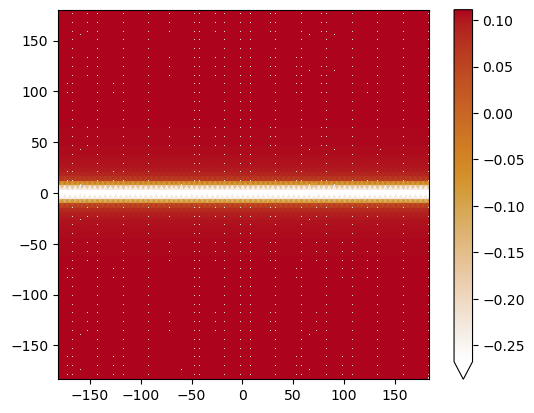

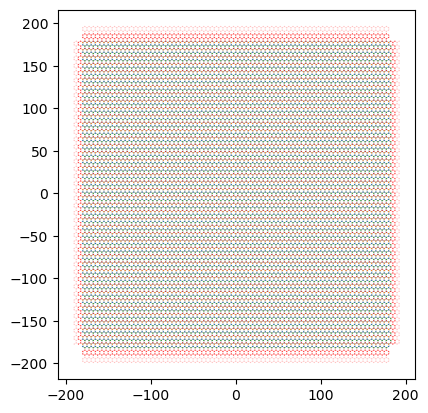

In [5]:
syst = system_maker()
kwant.plotter.map(syst, lambda ss: potential(ss, 15, -13.5))
kwant.plot(syst)
fsyst = syst.finalized()

Text(0, 0.5, 'T')

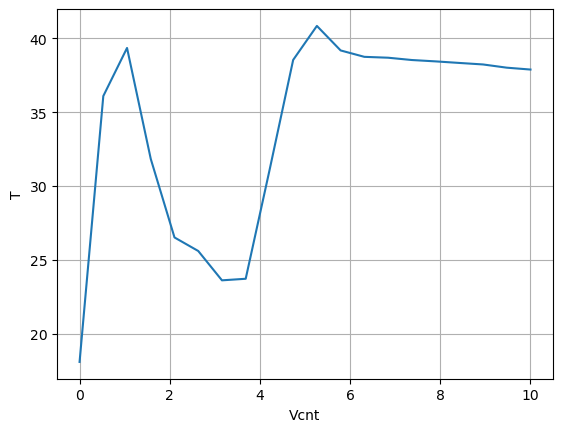

In [6]:
Vcnt_array = np.linspace(0, 10, 20)
T = np.zeros_like(Vcnt_array)

for i in range(len(Vcnt_array)):
    smatrix = kwant.smatrix(fsyst, energy=0, params=dict(Vcnt=Vcnt_array[i], Vbg=-13.5))
    T[i] = smatrix.transmission(1, 0)

plt.plot(Vcnt_array, T)
plt.grid()
plt.xlabel("Vcnt")
plt.ylabel("T")

C:\Users\renar\AppData\Local\Temp\ipykernel_16476\1643375957.py:4: RuntimeWarning: The plotted data contains 1.39% of values overflowing upper limit 8.62545 
  kwant.plotter.map(fsyst, np.sum(abs(scattering_wf)**2, axis=0)) # to map the wave function


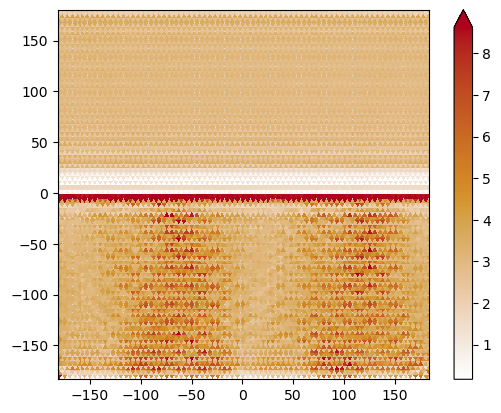

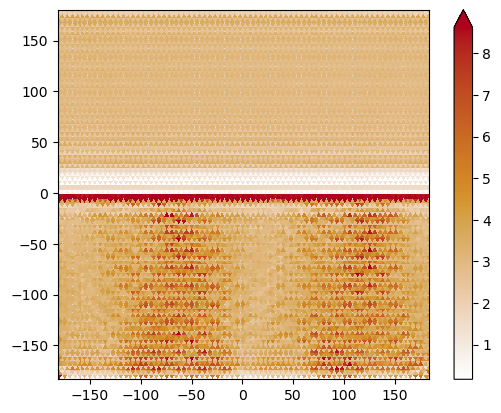

In [7]:
wfs = kwant.wave_function(fsyst, params=dict(Vcnt=15, Vbg=-13.5))
scattering_wf = wfs(0)

kwant.plotter.map(fsyst, np.sum(abs(scattering_wf)**2, axis=0)) # to map the wave function
# local_dos = kwant.ldos(fsyst, energy=0, params=dict(Vcnt=2, Vbg=-1))

# kwant.plotter.map(fsyst, local_dos, num_lead_cells=3)


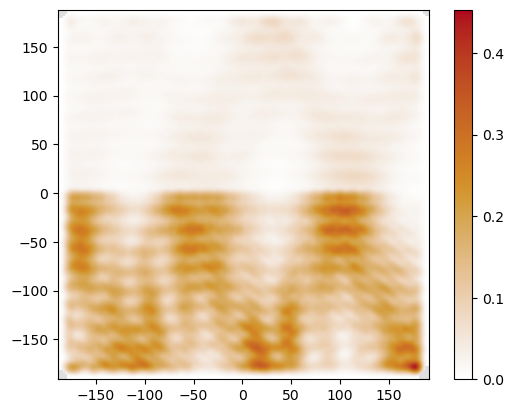

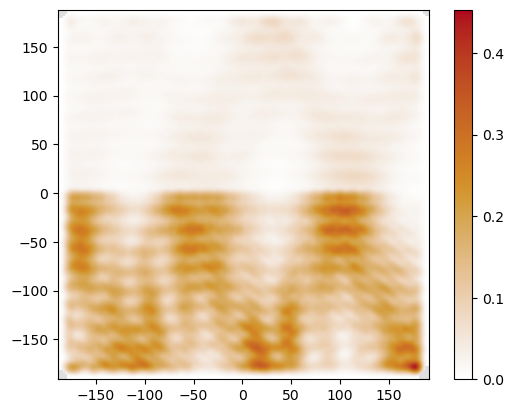

In [8]:
wf = kwant.wave_function(fsyst, energy=0, params=dict(Vcnt=5, Vbg=-13.5))
psi = wf(0)[3]

density = kwant.operator.Density(fsyst) # WHAT DENSITY IS THAT? COULD I VISUALIZE MY POTENTIAL???
pot = density(psi, params=dict(Vcnt=3, Vbg=-13.5))

kwant.plotter.density(fsyst, pot)

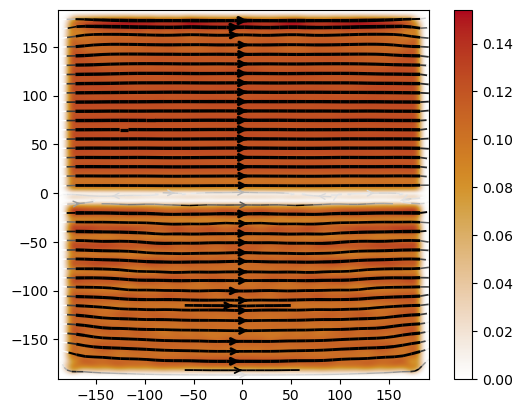

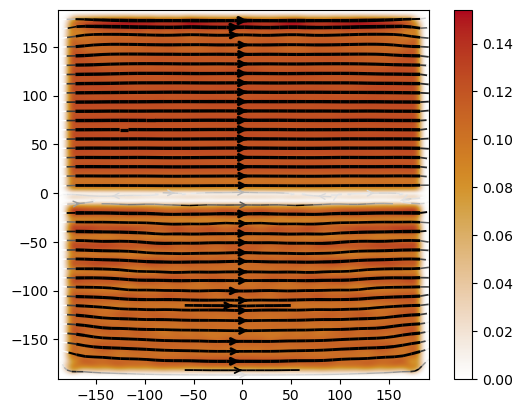

In [9]:
wf = kwant.wave_function(fsyst, energy=0, params=dict(Vcnt=5, Vbg=-13.5))
psi = wf(0)[2]

J = kwant.operator.Current(fsyst)
current = [J(psi) for psi in wf(0)]

kwant.plotter.current(fsyst, sum(current))